In [58]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [59]:
task = "patho_and_likelypatho" 
negative_cls = "neutral"
positive_cls = "likely_pathogenic" # pathogenic, likely_pathogenic
model_root_and_name_tuple_list = [("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("", "random_classifier")]

# by default, we consider larger means positive class (here pathogenic or likely-pathogenic), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["KS-statistic", "KS-pvalue", "AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [60]:
columns = ['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
            'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
            'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
            'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
            'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
            'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
            'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
            'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
            'prottrans_t5_xl_u50_pred']

patho_and_likelypatho_result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}_analysis.csv", sep="\t")
patho_and_likelypatho_result_df = patho_and_likelypatho_result_df.rename(columns={"clinvar_id":"id"})
patho_and_likelypatho_result_df = patho_and_likelypatho_result_df[columns]


popu_freq_result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/popu_freq_analysis.csv", sep="\t")
popu_freq_result_df = popu_freq_result_df[(popu_freq_result_df["class"]=="Common") | (popu_freq_result_df["class"]=="Rare")]
popu_freq_result_df["class"] = negative_cls
popu_freq_result_df = popu_freq_result_df.rename(columns={"snp_id":"id"})
popu_freq_result_df = popu_freq_result_df[columns]


patho_and_likelypatho_result_df_unique_prots_list = patho_and_likelypatho_result_df["prot_acc_version"].unique()
popu_freq_result_df = popu_freq_result_df[popu_freq_result_df["prot_acc_version"].isin(patho_and_likelypatho_result_df_unique_prots_list)] # variants must be of same proteins/genes from patho_and_likelypatho

print(popu_freq_result_df.shape)
print(popu_freq_result_df.columns)

print(patho_and_likelypatho_result_df.shape)
print(patho_and_likelypatho_result_df.columns)

result_df = pd.concat([popu_freq_result_df, patho_and_likelypatho_result_df])

(3639, 29)
Index(['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
       'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
       'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
       'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
       'prottrans_t5_xl_u50_pred'],
      dtype='object')
(6476, 29)
Index(['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
 

### Computing all methods performance metrics

In [68]:
def get_non_nan_df(df, col_name):
    non_nan_df = df[~pd.isna(df[col_name])]  # taking df for only non-NAN values
    
    n_missing = df[pd.isna(df[col_name])].shape[0] 
    total = df.shape[0]
    missing_values_percentage = (n_missing / total) * 100
    print(f"\tMissing values: 100*{n_missing}/{total}={missing_values_percentage}")
    
    return non_nan_df, missing_values_percentage

def calibrate_prediction_scores_direction(df, model_name):
    if model_name in models_smaller_means_damaging:
        df['pred'] = df['pred'].multiply(-1)
    
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(df)
    if not larger_means_positive_class:
        df['pred'] = df['pred'].multiply(-1)
    
    return df, auc_roc_score

def sample_positive_and_negative_data_points(df):
    df = df.copy(deep=True)
    positive_cls_result_df = df[df["class"]==positive_cls]
    negative_cls_result_df = df[df["class"]==negative_cls]
    
    positive_cls_result_df["class_numeric"] = 1
    negative_cls_result_df["class_numeric"] = 0

    positive_cls_unique_prots_list = positive_cls_result_df["prot_acc_version"].unique()
    negative_cls_result_df = negative_cls_result_df[negative_cls_result_df["prot_acc_version"].isin(positive_cls_unique_prots_list)] # variants must be of same proteins/genes from patho_and_likelypatho
    print(f"\t{positive_cls}(+ve): {positive_cls_result_df.shape}, {negative_cls}(-ve): {negative_cls_result_df.shape}")
    
    result_df = pd.concat([positive_cls_result_df, negative_cls_result_df])
    return result_df

def get_pathogenic_analysis_threshold(model_name):
    patho_performance_metrics_df = pd.read_csv(home_dir+f"models/aa_common/performance_analysis/{task}_pathogenic_vs_{negative_cls}_analysis.csv", sep="\t")
    patho_th_max = patho_performance_metrics_df[patho_performance_metrics_df["Models\\Metrics"]==model_name]["Th-max"]
    patho_th_max = float(patho_th_max)
    print(f"\tComputed th from pathogenic-analysis: {patho_th_max}")
    return patho_th_max


In [69]:
performance_scores_dict = {}

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"

    sampled_result_df = sample_positive_and_negative_data_points(result_df)
        
    if model_name=="random_classifier": sampled_result_df[model_pred_col] = [random.uniform(0, 1) for i in range(sampled_result_df.shape[0])]
    
    sampled_result_df["pred"]=(sampled_result_df[model_pred_col]-sampled_result_df[model_pred_col].min())/(sampled_result_df[model_pred_col].max()-sampled_result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
    
    non_nan_result_df, missing_values_percentage = get_non_nan_df(sampled_result_df, model_pred_col)
    
    non_nan_result_df, auc_roc_score =  calibrate_prediction_scores_direction(non_nan_result_df, model_name)
    
    ks_statistic, ks_pvalue = get_KS_test_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)

    if positive_cls=="likely_pathogenic": th_max =  get_pathogenic_analysis_threshold(model_name)
    
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
    
    performance_scores = [ks_statistic, ks_pvalue, auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc, missing_values_percentage]
        
    performance_scores_dict[model_name] = performance_scores

sift
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*1026/6697=15.320292668358967
	AUC-ROC: 0.859
	KS-test score. statistic: 0.580, p-value: 0.000
	AUC-PR: 0.905
	Best F1-Score: 0.852 at threshold: -0.050
	Computed th from pathogenic-analysis: -0.017
	Precision score: 0.854 at threshold: -0.017
	Recall score: 0.813 at threshold: -0.017
	Accuracy score: 0.794 at threshold: -0.017
	Balanced accuracy score: 0.788 at threshold: -0.017
	MCC score: 0.567 at threshold: -0.017
polyphen2_HVAR
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*1138/6697=16.99268329102583
	AUC-ROC: 0.861


/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_254570/2822459850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_254570/2822459850.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.579, p-value: 0.000
	AUC-PR: 0.900
	Best F1-Score: 0.858 at threshold: 0.273
	Computed th from pathogenic-analysis: 0.518
	Precision score: 0.836 at threshold: 0.518
	Recall score: 0.863 at threshold: 0.518
	Accuracy score: 0.806 at threshold: 0.518
	Balanced accuracy score: 0.786 at threshold: 0.518
	MCC score: 0.580 at threshold: 0.518
cadd
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*833/6697=12.438405256084813
	AUC-ROC: 0.864
	KS-test score. statistic: 0.595, p-value: 0.000
	AUC-PR: 0.882
	Best F1-Score: 0.874 at threshold: 0.444
	Computed th from pathogenic-analysis: 0.476
	Precision score: 0.830 at threshold: 0.476
	Recall score: 0.903 at threshold: 0.476
	Accuracy score: 0.822 at threshold: 0.476
	Balanced accuracy score: 0.793 at threshold: 0.476
	MCC score: 0.610 at threshold: 0.476
mvp
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*1520/6697=22.69672987905032
	AUC-ROC: 0.806

/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_254570/2822459850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.498, p-value: 0.000
	AUC-PR: 0.894
	Best F1-Score: 0.855 at threshold: 0.596
	Computed th from pathogenic-analysis: 0.68
	Precision score: 0.794 at threshold: 0.680
	Recall score: 0.924 at threshold: 0.680
	Accuracy score: 0.775 at threshold: 0.680
	Balanced accuracy score: 0.665 at threshold: 0.680
	MCC score: 0.396 at threshold: 0.680
metarnn
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*841/6697=12.557861729132448
	AUC-ROC: 0.978
	KS-test score. statistic: 0.905, p-value: 0.000
	AUC-PR: 0.978
	Best F1-Score: 0.969 at threshold: 0.220
	Computed th from pathogenic-analysis: 0.288
	Precision score: 0.957 at threshold: 0.288
	Recall score: 0.980 at threshold: 0.288
	Accuracy score: 0.959 at threshold: 0.288
	Balanced accuracy score: 0.952 at threshold: 0.288
	MCC score: 0.912 at threshold: 0.288
revel
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*950/6697=14.185456174406449
	AUC-ROC: 0

/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_254570/2822459850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*0/6697=0.0
	AUC-ROC: 0.524
	KS-test score. statistic: 0.092, p-value: 0.000
	AUC-PR: 0.663
	Best F1-Score: 0.767 at threshold: 0.000
	Computed th from pathogenic-analysis: 0.0
	Precision score: 0.622 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.622 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000
protbert
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*0/6697=0.0
	AUC-ROC: 0.463
	KS-test score. statistic: 0.077, p-value: 0.000
	AUC-PR: 0.682
	Best F1-Score: 0.767 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.846
	Precision score: 0.623 at threshold: -0.846
	Recall score: 0.996 at threshold: -0.846
	Accuracy score: 0.622 at threshold: -0.846
	Balanced accuracy score: 0.501 at threshold: -0.846
	MCC score: 0.010 at threshold: -0.846
sequnet
	likely_pathogenic(+

/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_254570/2822459850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.571, p-value: 0.000
	AUC-PR: 0.890
	Best F1-Score: 0.849 at threshold: -0.565
	Computed th from pathogenic-analysis: -0.495
	Precision score: 0.844 at threshold: -0.495
	Recall score: 0.820 at threshold: -0.495
	Accuracy score: 0.794 at threshold: -0.495
	Balanced accuracy score: 0.785 at threshold: -0.495
	MCC score: 0.566 at threshold: -0.495
esm1v_t33_650M_UR90S
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*0/6697=0.0
	AUC-ROC: 0.155
	KS-test score. statistic: 0.569, p-value: 0.000
	AUC-PR: 0.888
	Best F1-Score: 0.840 at threshold: -0.618
	Computed th from pathogenic-analysis: -0.466


/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_254570/2822459850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.897 at threshold: -0.466
	Recall score: 0.597 at threshold: -0.466
	Accuracy score: 0.707 at threshold: -0.466
	Balanced accuracy score: 0.742 at threshold: -0.466
	MCC score: 0.477 at threshold: -0.466
esm2_t33_650M_UR50D
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*0/6697=0.0
	AUC-ROC: 0.173
	KS-test score. statistic: 0.536, p-value: 0.000
	AUC-PR: 0.879
	Best F1-Score: 0.826 at threshold: -0.488
	Computed th from pathogenic-analysis: -0.424
	Precision score: 0.849 at threshold: -0.424
	Recall score: 0.755 at threshold: -0.424
	Accuracy score: 0.764 at threshold: -0.424
	Balanced accuracy score: 0.767 at threshold: -0.424
	MCC score: 0.521 at threshold: -0.424
plus_rnn
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*0/6697=0.0
	AUC-ROC: 0.442
	KS-test score. statistic: 0.133, p-value: 0.000
	AUC-PR: 0.706
	Best F1-Score: 0.767 at threshold: -0.898
	Computed th from pathogenic-analysis: -0.881

/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_254570/2822459850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.532, p-value: 0.000
	AUC-PR: 0.873
	Best F1-Score: 0.807 at threshold: -0.508
	Computed th from pathogenic-analysis: -0.532
	Precision score: 0.777 at threshold: -0.532
	Recall score: 0.830 at threshold: -0.532
	Accuracy score: 0.746 at threshold: -0.532
	Balanced accuracy score: 0.719 at threshold: -0.532
	MCC score: 0.449 at threshold: -0.532
prottrans_albert_bfd
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*0/6697=0.0
	AUC-ROC: 0.173


/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_254570/2822459850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0


	KS-test score. statistic: 0.542, p-value: 0.000
	AUC-PR: 0.870
	Best F1-Score: 0.829 at threshold: -0.450
	Computed th from pathogenic-analysis: -0.468
	Precision score: 0.779 at threshold: -0.468
	Recall score: 0.879 at threshold: -0.468
	Accuracy score: 0.769 at threshold: -0.468
	Balanced accuracy score: 0.734 at threshold: -0.468
	MCC score: 0.495 at threshold: -0.468
prottrans_xlnet_uniref100
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*0/6697=0.0
	AUC-ROC: 0.409
	KS-test score. statistic: 0.212, p-value: 0.000
	AUC-PR: 0.741
	Best F1-Score: 0.767 at threshold: -1.000
	Computed th from pathogenic-analysis: -1.0
	Precision score: 0.622 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.622 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000
prottrans_t5_bfd
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*0/6697=0.0
	AU

/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_254570/2822459850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_254570/2822459850.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.622 at threshold: -0.990
	Recall score: 1.000 at threshold: -0.990
	Accuracy score: 0.622 at threshold: -0.990
	Balanced accuracy score: 0.500 at threshold: -0.990
	MCC score: 0.000 at threshold: -0.990
random_classifier
	likely_pathogenic(+ve): (4168, 30), neutral(-ve): (2529, 30)
	Missing values: 100*0/6697=0.0
	AUC-ROC: 0.503
	KS-test score. statistic: 0.017, p-value: 0.736
	AUC-PR: 0.623
	Best F1-Score: 0.767 at threshold: 0.001
	Computed th from pathogenic-analysis: 0.0
	Precision score: 0.622 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.622 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000


In [70]:
output_file = home_dir+f"models/aa_common/performance_analysis/{task}_{positive_cls}_vs_{negative_cls}_analysis.csv"

out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")

for (model_name, performance_scores) in performance_scores_dict.items():
    out.write(f"{model_name}")
    for score in performance_scores:
        out.write(f"\t{score:.3f}")
    out.write("\n")

out.close()

### Plotting the prediction score distributions

sift
	Missing values: 100*1506/10115=14.888779041028178


/tmp/ipykernel_254570/2495000420.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


polyphen2_HVAR
	Missing values: 100*1655/10115=16.361838853188335
cadd
	Missing values: 100*1224/10115=12.100840336134453
mvp
	Missing values: 100*2304/10115=22.778052397429562
metarnn
	Missing values: 100*1236/10115=12.219476025704399
revel
	Missing values: 100*1389/10115=13.732081067721206
unirep
	Missing values: 100*0/10115=0.0
protbert
	Missing values: 100*0/10115=0.0
sequnet
	Missing values: 100*12/10115=0.11863568956994562


/tmp/ipykernel_254570/2495000420.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


esm1b_t33_650M_UR50S
	Missing values: 100*0/10115=0.0
esm1v_t33_650M_UR90S
	Missing values: 100*0/10115=0.0
esm2_t33_650M_UR50D
	Missing values: 100*0/10115=0.0
plus_rnn
	Missing values: 100*0/10115=0.0
prottrans_bert_bfd
	Missing values: 100*0/10115=0.0
prottrans_albert_bfd
	Missing values: 100*0/10115=0.0
prottrans_xlnet_uniref100
	Missing values: 100*0/10115=0.0
prottrans_t5_bfd
	Missing values: 100*0/10115=0.0
prottrans_t5_uniref50
	Missing values: 100*0/10115=0.0
prottrans_t5_xl_u50
	Missing values: 100*0/10115=0.0
random_classifier
	Missing values: 100*0/10115=0.0


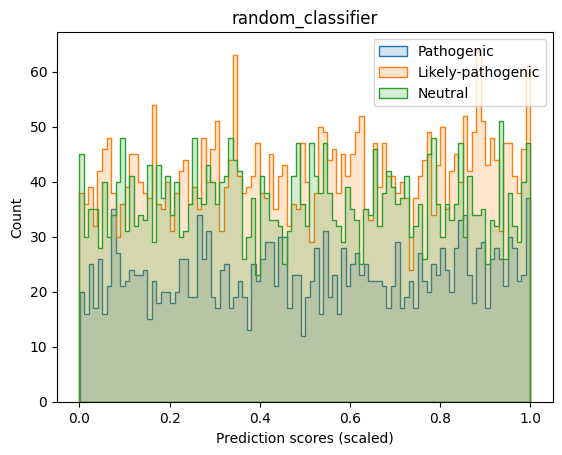

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(result_df):
    df = result_df.copy(deep=True)
    plt.cla()

    patho = result_df[result_df["class"]=="pathogenic"]
    likely_patho = result_df[result_df["class"]=="likely_pathogenic"]
    neutral = result_df[result_df["class"]=="neutral"]

    bins = 100 # 20, 100, 500
    # plt.hist(knock_out["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Knock-out")
    # plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No-effect")
    # plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Effect")
    
    sns.histplot(patho["pred"], bins=bins, label=f"Pathogenic", element="step", alpha=.2)
    sns.histplot(likely_patho["pred"], bins=bins, label=f"Likely-pathogenic", element="step", alpha=.2)
    sns.histplot(neutral["pred"], bins=bins, label=f"Neutral", element="step", alpha=.2)
    
    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"models/aa_common/pred_scores_distribution_plots_pathogenicity_analysis/{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)


for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    # model_name = "esm2_t33_650M_UR50D"
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        result_df[model_pred_col] = [random.uniform(0,1) for i in range(result_df.shape[0])]

    result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df, _ = get_non_nan_df(result_df, model_pred_col)
        
    if model_name in models_smaller_means_damaging:
        non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)

    plot_distribution(non_nan_result_df)
    # break

### For debugging purpose only

	AUC-ROC: 0.177
	AUC-PR: 0.808
(8302,)
	Best F1-Score: 0.769 at threshold: -0.508
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: 0.001


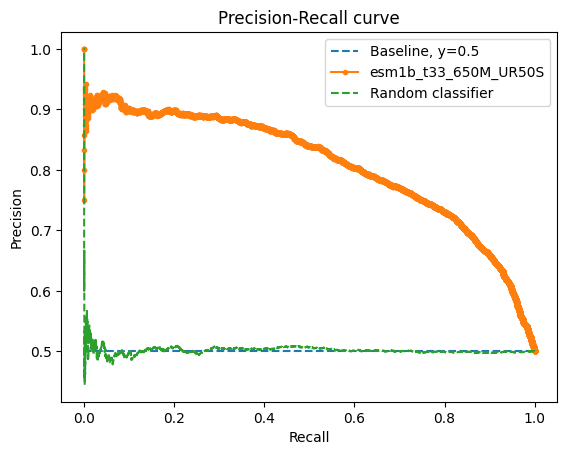

In [7]:
result_df = list_of_resut_df[0]
model_name = "esm1b_t33_650M_UR50S" # polyphen2_HVAR, esm1b_t33_650M_UR50S
model_pred_col = model_name + "_pred"

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
if not larger_means_positive_class:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

# print(thresholds.shape)
# print(precisions)
# print(recalls)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')# precisions_list.append(p)
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')


import random
result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
auc_pr_score, p, r, t = get_auc_pr_score(non_nan_result_df)
f1_max, th_max, p, r, t = get_f1max_and_th(p, r, t)
plt.plot(r, p, linestyle='--', label="Random classifier")


plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


# pathogenicity = result_df[result_df["class"]==task]
# neutral = result_df[result_df["class"]=="neutral"]

# bins = 100 # 20, 100, 500
# plt.hist(pathogenicity["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Pathogenicity-{model_name}")
# plt.hist(neutral["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Neutral-{model_name}")

# plt.legend()
# plt.show()

In [14]:
import random

model_name = "random_classifier"
auc_roc_score_list, auc_pr_score_list, f1_max_list, th_max_list, precision_list, recall_list, accuracy_list, balanced_accuracy_list, mcc_list = [], [], [], [], [], [], [], [], []

for i in range(10):
    result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
    non_nan_result_df = result_df
        
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)

    auc_roc_score_list.append(auc_roc_score)
    auc_pr_score_list.append(auc_pr_score)
    f1_max_list.append(f1_max)
    th_max_list.append(th_max)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    mcc_list.append(mcc)
    

permformance_scores = [np.mean(auc_roc_score_list), np.mean(auc_pr_score_list), np.mean(f1_max_list), 
                       np.mean(th_max_list), np.mean(precision_list), np.mean(recall_list), 
                       np.mean(accuracy_list), np.mean(balanced_accuracy_list), np.mean(mcc_list), 0.0]

output_file = home_dir+f"models/aa_common/performance_analysis/{task}_analysis/avg.csv"    
# output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"
out = open(output_file, 'a')

out.write(f"{model_name}")
for score in permformance_scores:
    out.write(f"\t{score:.3f}")
out.write("\n")
out.close()

	AUC-ROC: 0.506
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.000 at threshold: 0.001
	AUC-ROC: 0.495
	AUC-PR: 0.497
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.026 at threshold: 0.001
	AUC-ROC: 0.502
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.026 at threshold: 0.001
	AUC-ROC: 0.508
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall sc